In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from tqdm import tqdm

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 계층적 샘플링을 위한 라이브러리
from sklearn.model_selection import train_test_split

# # 3, 4단계 머신러닝 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, \
    confusion_matrix

In [3]:
# (선택) 한글 폰트 설정 (시각화 시)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
except:
    pass  # Windows가 아닐 경우 무시
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
warnings.filterwarnings('ignore')

print("--- 0. 라이브러리 임포트 완료 ---")

--- 0. 라이브러리 임포트 완료 ---


In [4]:
# --- 1. 데이터 로드 및 전처리 설정 ---

# CICIOT2023 CSV 파일 디렉터리 경로
DATASET_DIRECTORY = 'CICIoT2023/'

# 샘플링 비율
SAMPLING_RATIO = 0.3

try:
    all_files = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    all_files.sort()
    print(f"\n--- 1. 데이터 로드 ---")
    print(f"총 {len(all_files)}개 CSV 파일 발견.")
    print(f"설정된 샘플링 비율: {SAMPLING_RATIO * 100}%")
except FileNotFoundError:
    print(f"오류: '{DATASET_DIRECTORY}' 경로를 찾을 수 없습니다.")
    exit()


--- 1. 데이터 로드 ---
총 169개 CSV 파일 발견.
설정된 샘플링 비율: 30.0%


In [5]:
# --- 2. 데이터 전처리 (피처/레이블 정의 및 매핑) ---

# # 4. X (특성)와 y (타겟) 분리 (컬럼 이름 정의)
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight',
]
y_column = 'label'

print(f"\n--- 2. 데이터 전처리 ---")
print(f"X (특성) 컬럼 {len(X_columns)}개 정의 완료.")
print(f"y (타겟) 컬럼 '{y_column}' 정의 완료.")

# 레이블 매핑 딕셔너리 정의
dict_8_classes = {
    'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing', 'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign', 'BrowserHijacking': 'Web', 'Backdoor_Malware': 'Web',
    'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web',
    'CommandInjection': 'Web', 'DictionaryBruteForce': 'BruteForce'
}
dict_2_classes = {'BenignTraffic': 'Benign'}

print("2-Class / 8-Class 레이블 매핑 딕셔너리 정의 완료.")


# 샘플링 기능이 추가된 데이터 로드/전처리 함수
def load_and_preprocess(files, description, sample_ratio):
    """파일 목록을 읽어 샘플링하고, 하나의 DataFrame으로 합친 후 전처리/스케일링합니다."""
    sampled_dfs = []
    print(f"\n{description} 데이터 로드 및 샘플링(비율 {sample_ratio * 100}%) 중...")

    for f in tqdm(files):
        file_path = os.path.join(DATASET_DIRECTORY, f)
        try:
            df = pd.read_csv(file_path, low_memory=False)

            # 1. NaN/Infinity 값을 0으로 대체 (스케일링 전)
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.fillna(0, inplace=True)

            # 2. 계층적 샘플링 (Stratified Sampling)
            try:
                _, df_sample = train_test_split(
                    df,
                    test_size=sample_ratio,  # test_size를 샘플링 비율로 사용
                    stratify=df[y_column],  # 레이블 비율 유지
                    random_state=42
                )
            except ValueError:
                df_sample = df.sample(frac=sample_ratio, random_state=42)

            sampled_dfs.append(df_sample)

        except Exception as e:
            print(f"파일 {f} 처리 중 오류: {e}")

    # 샘플링된 모든 DataFrame을 하나로 합침
    full_df = pd.concat(sampled_dfs, ignore_index=True)

    # 3. X(특성)와 y(타겟) 분리
    X = full_df[X_columns]
    y_raw = full_df[y_column]

    # 4. 스케일링 적용 (scaler는 3단계에서 미리 fit 되어 있어야 함)
    X_scaled = scaler.transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_columns)

    return X_scaled_df, y_raw


print("\n--- 2. 데이터 전처리 완료 ---")


--- 2. 데이터 전처리 ---
X (특성) 컬럼 46개 정의 완료.
y (타겟) 컬럼 'label' 정의 완료.
2-Class / 8-Class 레이블 매핑 딕셔너리 정의 완료.

--- 2. 데이터 전처리 완료 ---



--- 3. 모델 훈련 ---
[데이터 분할 현황]
훈련용 파일 135개, 테스트용 파일 34개.

[데이터 스케일링 완료 (StandardScaler)]
훈련 파일들로 StandardScaler 학습(fitting) 중 (시간이 오래 걸릴 수 있습니다)...


100%|██████████| 135/135 [03:28<00:00,  1.55s/it]


StandardScaler 학습 완료.

훈련 데이터 로드 및 샘플링(비율 30.0%) 중...


100%|██████████| 135/135 [04:19<00:00,  1.92s/it]



테스트 데이터 로드 및 샘플링(비율 30.0%) 중...


100%|██████████| 34/34 [01:37<00:00,  2.87s/it]



[데이터 샘플링 후 Shape]
X_train shape: (10903988, 46), y_train shape: (10903988,)
X_test shape: (3102066, 46), y_test shape: (3102066,)

--- 1-bis. 상세 EDA (샘플링된 훈련 데이터 기준) ---
[시각화] 'eda_1_pie_2_classes.png' 저장 완료
[시각화] 'eda_2_bar_top20_labels.png' 저장 완료 (로그 스케일)
[시각화] 주요 특성 ['flow_duration', 'Rate', 'Tot sum', 'AVG'] 박스플롯 저장 중...
[시각화] 'eda_3_feature_boxplot.png' 저장 완료
[시각화] 주요 특성 상관관계 히트맵 저장 중...
[시각화] 'eda_4_correlation_heatmap.png' 저장 완료


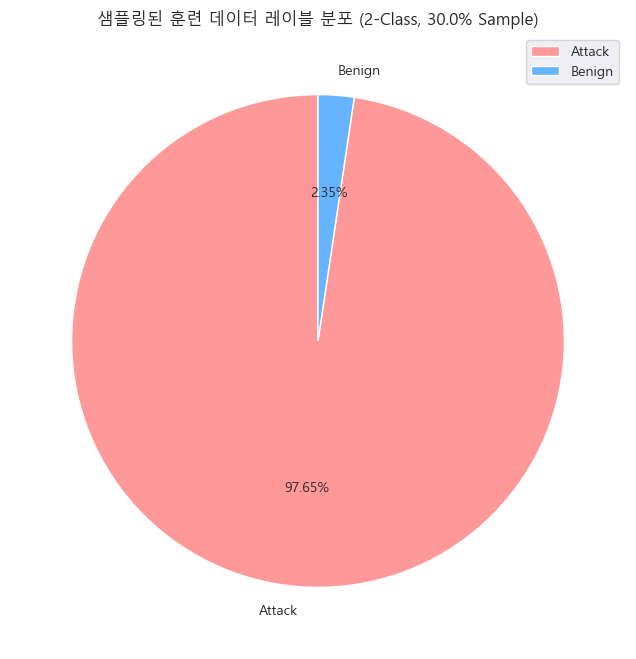

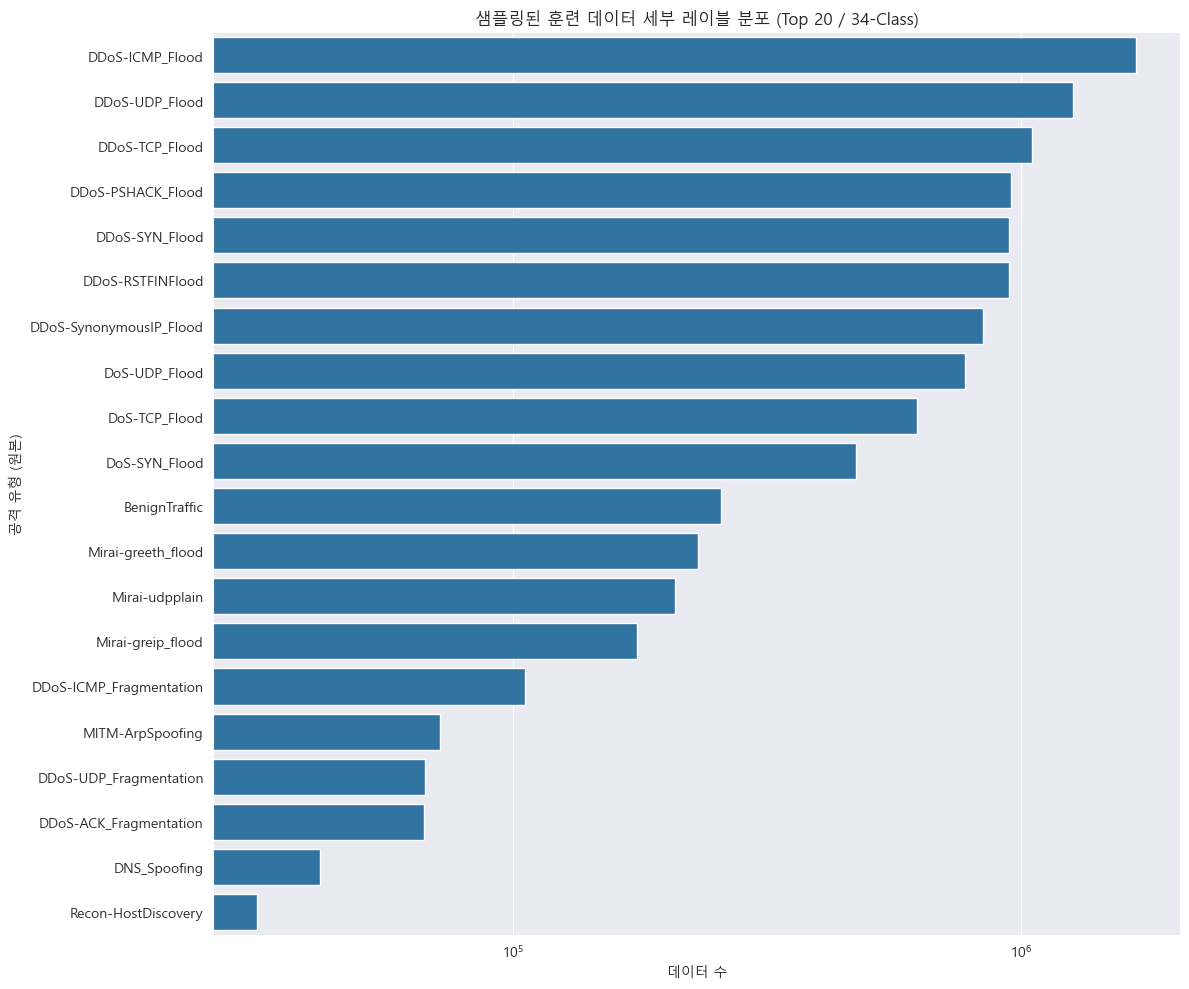

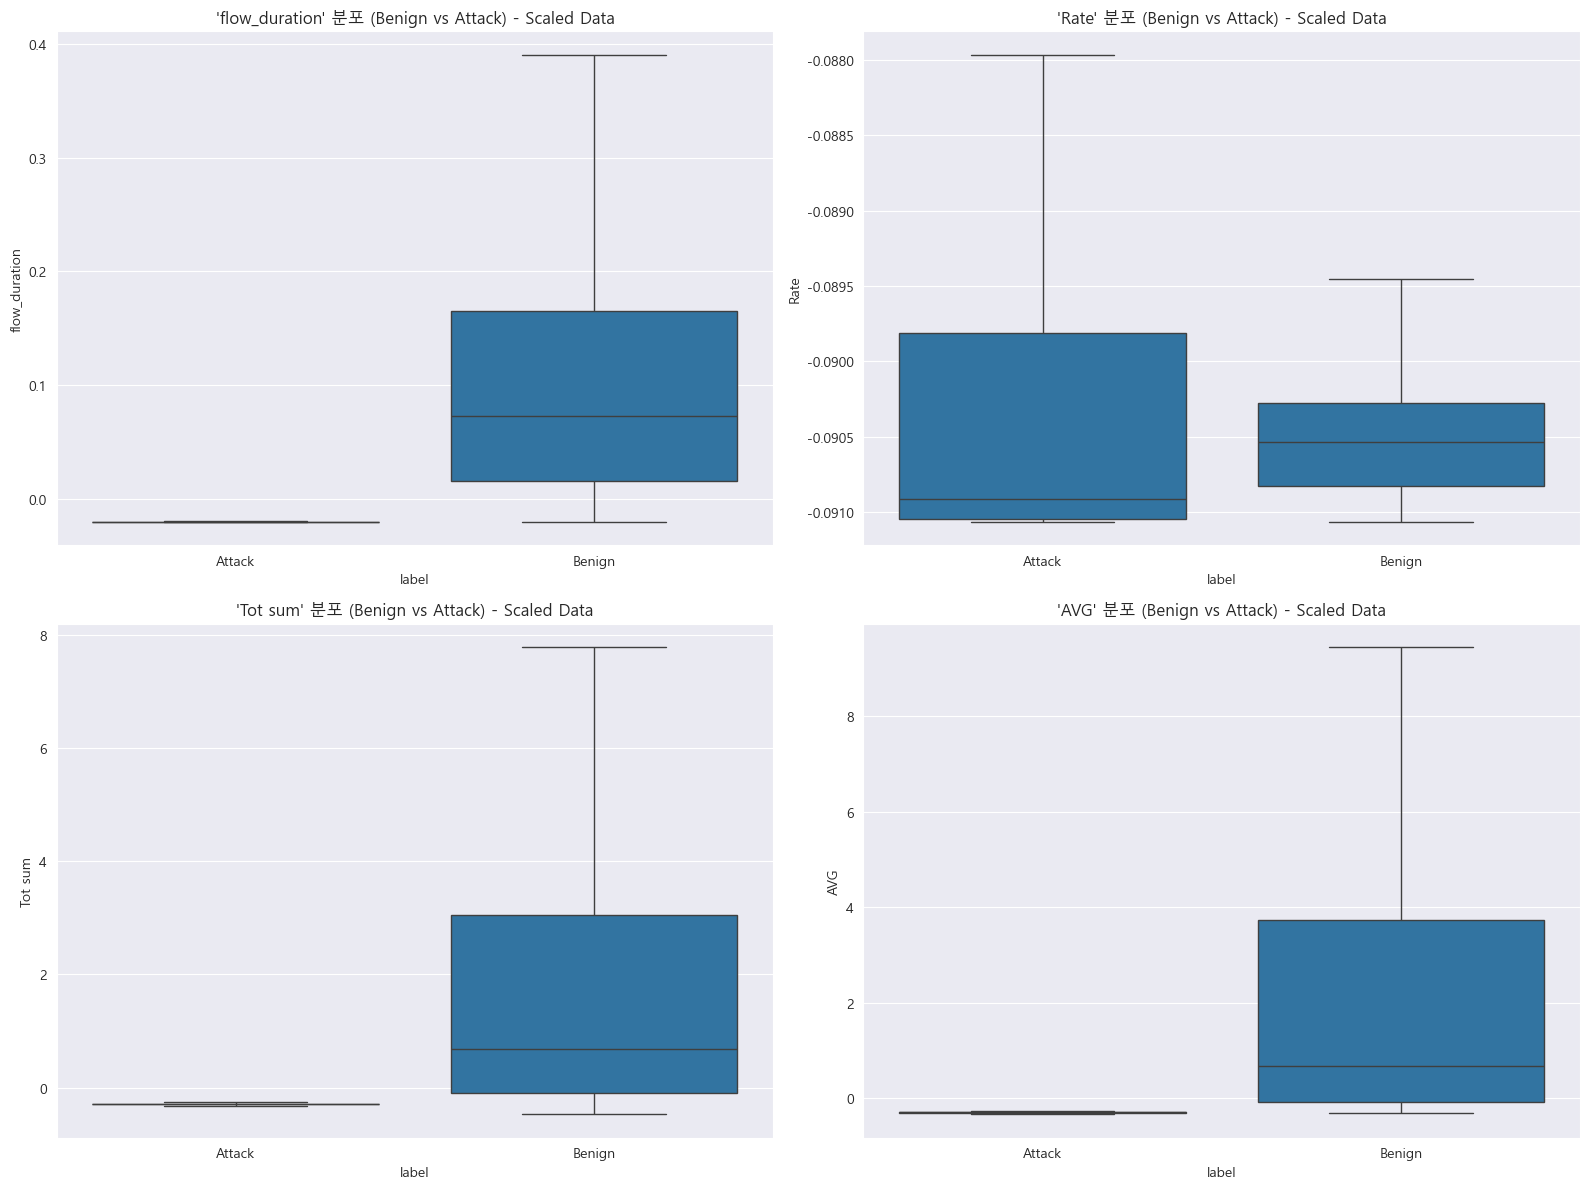

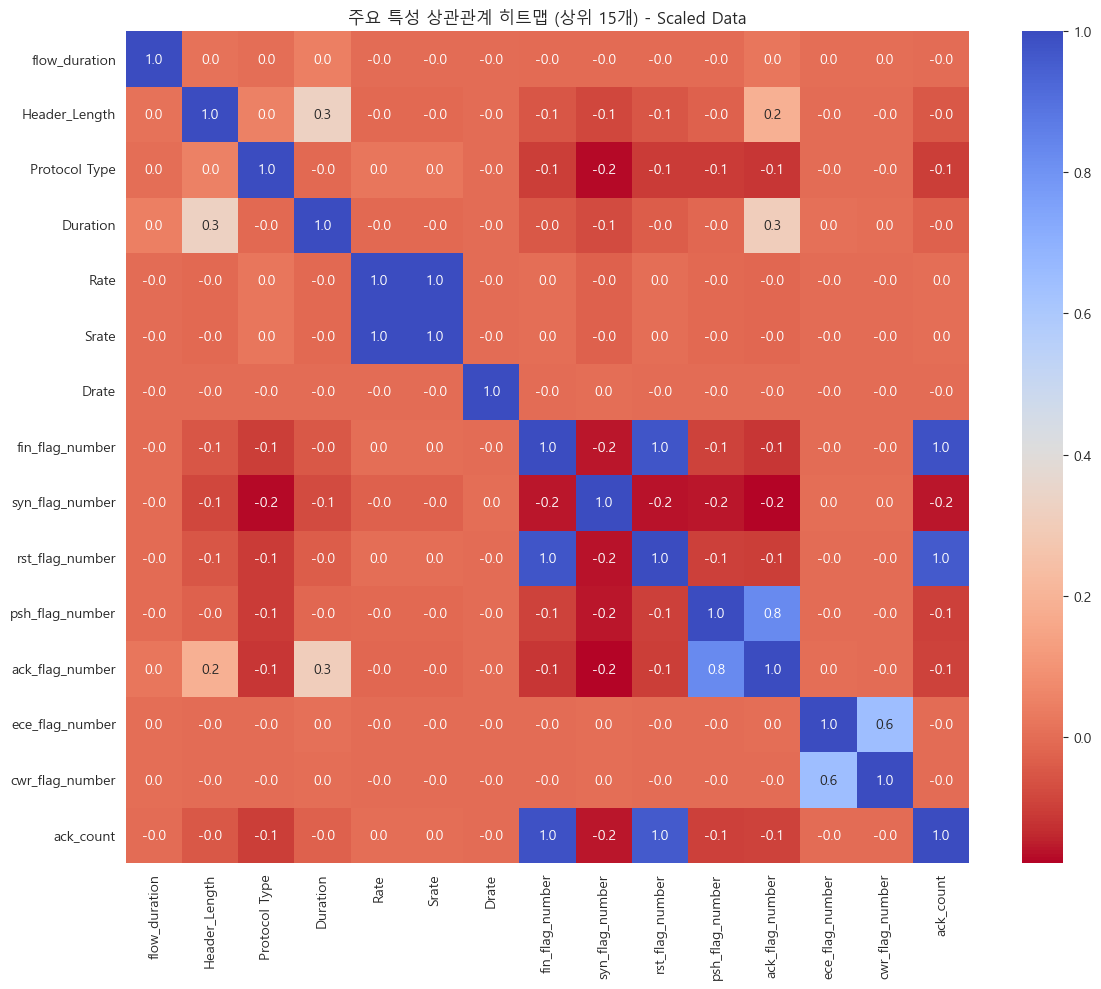

In [6]:
# --- 3. 모델 훈련 시작 ---

# 훈련/테스트 데이터 분할 (80:20)
split_index = int(len(all_files) * 0.8)
training_files = all_files[:split_index]
test_files = all_files[split_index:]

print(f"\n--- 3. 모델 훈련 ---")
print(f"[데이터 분할 현황]")
print(f"훈련용 파일 {len(training_files)}개, 테스트용 파일 {len(test_files)}개.")

# 데이터 스케일링 (학습)
print("\n[데이터 스케일링 완료 (StandardScaler)]")
print("훈련 파일들로 StandardScaler 학습(fitting) 중 (시간이 오래 걸릴 수 있습니다)...")
scaler = StandardScaler()
for train_set_file in tqdm(training_files):
    file_path = os.path.join(DATASET_DIRECTORY, train_set_file)
    try:
        df_chunk = pd.read_csv(file_path, usecols=X_columns, low_memory=False)
        df_chunk.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_chunk.fillna(0, inplace=True)
        scaler.partial_fit(df_chunk)  # 점진적 학습
    except Exception as e:
        print(f"파일 {train_set_file} 처리 중 오류: {e}")
del df_chunk
print("StandardScaler 학습 완료.")

# (개선) 샘플링된 훈련/테스트 데이터 로드
try:
    X_train, y_train_raw = load_and_preprocess(training_files, "훈련", sample_ratio=SAMPLING_RATIO)
    X_test, y_test_raw = load_and_preprocess(test_files, "테스트", sample_ratio=SAMPLING_RATIO)

    print(f"\n[데이터 샘플링 후 Shape]")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_raw.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test_raw.shape}")

except MemoryError:
    print(f"\n[오류] 샘플링(현재 {SAMPLING_RATIO * 100}%) 후에도 메모리 부족.")
    print("스크립트 상단의 SAMPLING_RATIO 값을 더 낮춰서 (예: 0.05) 다시 시도해주세요.")
    exit()

# 시나리오별 y (타겟) 데이터 생성
y_train_34 = y_train_raw
y_test_34 = y_test_raw
y_train_8 = y_train_raw.map(dict_8_classes).fillna('Benign')
y_test_8 = y_test_raw.map(dict_8_classes).fillna('Benign')
y_train_2 = y_train_raw.map(dict_2_classes).fillna('Attack')
y_test_2 = y_test_raw.map(dict_2_classes).fillna('Attack')

# --- 1-bis. 📊 상세한 탐색적 데이터 분석 (EDA) (샘플링 데이터 활용) ---
print(f"\n--- 1-bis. 상세 EDA (샘플링된 훈련 데이터 기준) ---")

# (추가) 1-1. (시각화) 2-Class (Attack/Benign) 분포 파이 차트
try:
    plt.figure(figsize=(8, 8))
    label_counts = y_train_2.value_counts()
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%',
            startangle=90, colors=['#ff9999', '#66b3ff'])
    plt.title(f'샘플링된 훈련 데이터 레이블 분포 (2-Class, {SAMPLING_RATIO * 100}% Sample)')
    plt.legend()
    plt.savefig("eda_1_pie_2_classes.png")
    print("[시각화] 'eda_1_pie_2_classes.png' 저장 완료")
except Exception as e:
    print(f"시각화 1 (파이 차트) 오류: {e}")

# (수정) 1-2. (시각화) 34-Class 세부 레이블 분포 (상위 20개)
try:
    plt.figure(figsize=(12, 10))
    # 원본 34개 클래스 중 상위 20개만
    top_20_labels = y_train_34.value_counts().nlargest(20)
    sns.barplot(y=top_20_labels.index, x=top_20_labels.values)
    plt.title(f'샘플링된 훈련 데이터 세부 레이블 분포 (Top 20 / 34-Class)')
    plt.xlabel('데이터 수')
    plt.ylabel('공격 유형 (원본)')
    plt.xscale('log')  # 수량 차이가 크므로 log 스케일
    plt.tight_layout()
    plt.savefig("eda_2_bar_top20_labels.png")
    print("[시각화] 'eda_2_bar_top20_labels.png' 저장 완료 (로그 스케일)")
except Exception as e:
    print(f"시각화 2 (세부 레이블) 오류: {e}")

# (추가) 1-3. (시각화) 주요 특성 분포 (Benign vs Attack) - Box Plot
try:
    features_to_plot = ['flow_duration', 'Rate', 'Tot sum', 'AVG']
    print(f"[시각화] 주요 특성 {features_to_plot} 박스플롯 저장 중...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    temp_df = X_train[features_to_plot].copy()
    # (주의) 스케일링된 데이터(X_train)는 이미 평균 0, 표준편차 1로 변환됨
    # 원본 분포를 보려면 load_and_preprocess에서 X(스케일링 전)를 반환해야 함
    # 여기서는 스케일링된 데이터의 분포를 비교
    temp_df['label'] = y_train_2.values

    for i, feature in enumerate(features_to_plot):
        sns.boxplot(data=temp_df, x='label', y=feature, ax=axes[i], showfliers=False)  # Outlier 제외
        axes[i].set_title(f"'{feature}' 분포 (Benign vs Attack) - Scaled Data")
        # (참고) Y축 스케일이 매우 작을 수 있음 (이미 스케일링됨)
        # axes[i].set_yscale('log') # Box plot은 log scale 적용이 까다로울 수 있음

    plt.tight_layout()
    plt.savefig("eda_3_feature_boxplot.png")
    print("[시각화] 'eda_3_feature_boxplot.png' 저장 완료")
    del temp_df
except Exception as e:
    print(f"시각화 3 (특성 박스플롯) 오류: {e}")

# 1-4. (시각화) 주요 특성 간 상관관계 히트맵 (유지)
try:
    print("[시각화] 주요 특성 상관관계 히트맵 저장 중...")
    corr_features = X_columns[:15]
    corr_matrix = X_train[corr_features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm_r')
    plt.title('주요 특성 상관관계 히트맵 (상위 15개) - Scaled Data')
    plt.tight_layout()
    plt.savefig("eda_4_correlation_heatmap.png")
    print("[시각화] 'eda_4_correlation_heatmap.png' 저장 완료")
    del corr_matrix
except Exception as e:
    print(f"시각화 4 (상관관계) 오류: {e}")

In [7]:
# # 4. 모델 생성 및 훈련 (EDA 완료 후 진행)
print("\n[모델 생성 및 훈련]")
# (max_iter=1000: 수렴 경고 방지)

print("LogisticRegression (2 classes) 훈련 시작...")
model_2 = LogisticRegression(n_jobs=-1, max_iter=1000)
model_2.fit(X_train, y_train_2)


[모델 생성 및 훈련]
LogisticRegression (2 classes) 훈련 시작...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
print("LogisticRegression (8 classes) 훈련 시작...")
model_8 = LogisticRegression(n_jobs=-1, max_iter=1000)
model_8.fit(X_train, y_train_8)

LogisticRegression (8 classes) 훈련 시작...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [9]:
print("LogisticRegression (34 classes) 훈련 시작...")
model_34 = LogisticRegression(n_jobs=-1, max_iter=1000)
model_34.fit(X_train, y_train_34)

print("\n--- 3. 모델 훈련 완료 ---")

LogisticRegression (34 classes) 훈련 시작...


KeyboardInterrupt: 

In [15]:
# --- 4. 모델 평가 및 해석 ---
print(f"\n--- 4. 모델 평가 및 해석 ---")

# # 2. 예측 수행
print("\n[테스트 데이터(X_test)에 대한 예측 완료]")
y_pred_2 = model_2.predict(X_test)
y_pred_8 = model_8.predict(X_test)
y_pred_34 = model_34.predict(X_test)


# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred, labels, model_name, filename):
    """Confusion Matrix를 시각화하고 저장하는 함수"""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        show_annot = len(labels) <= 10

        plt.figure(figsize=(max(10, len(labels) * 0.8), max(8, len(labels) * 0.6)))
        sns.heatmap(cm, annot=show_annot, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(filename)
        print(f"[시각화] '{filename}' 저장 완료")
    except Exception as e:
        print(f"시각화 (혼동 행렬: {model_name}) 오류: {e}")


--- 4. 모델 평가 및 해석 ---

[테스트 데이터(X_test)에 대한 예측 완료]



##### LogisticRegression (2 classes) #####
[정확도(Accuracy)]: 0.9890 (약 98.90%)

[분류 리포트(Classification Report)]: (average='binary')
              precision    recall  f1-score   support

      Attack       0.99      1.00      0.99   3029071
      Benign       0.79      0.73      0.76     72995

    accuracy                           0.99   3102066
   macro avg       0.89      0.86      0.88   3102066
weighted avg       0.99      0.99      0.99   3102066

* Precision (정밀도 - binary): 0.9935
* Recall (재현율 - binary): 0.9952
* F1-score (조화 평균 - binary): 0.9944
[시각화] 'eval_cm_2_classes.png' 저장 완료

##### LogisticRegression (8 classes) #####
[정확도(Accuracy)]: 0.8766 (약 87.66%)

[분류 리포트(Classification Report)]: (average='macro')
              precision    recall  f1-score   support

      Benign       0.73      0.91      0.81     72995
  BruteForce       0.92      0.16      0.27       895
        DDoS       0.87      0.99      0.93   2257857
         DoS       0.92      0.40      0.56    537659


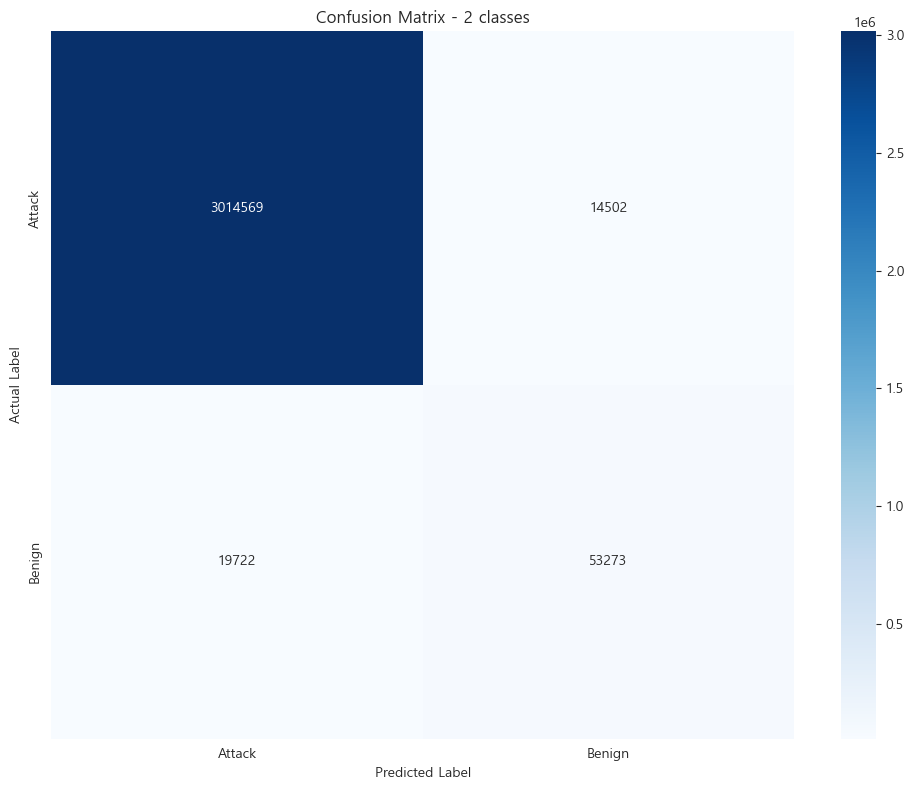

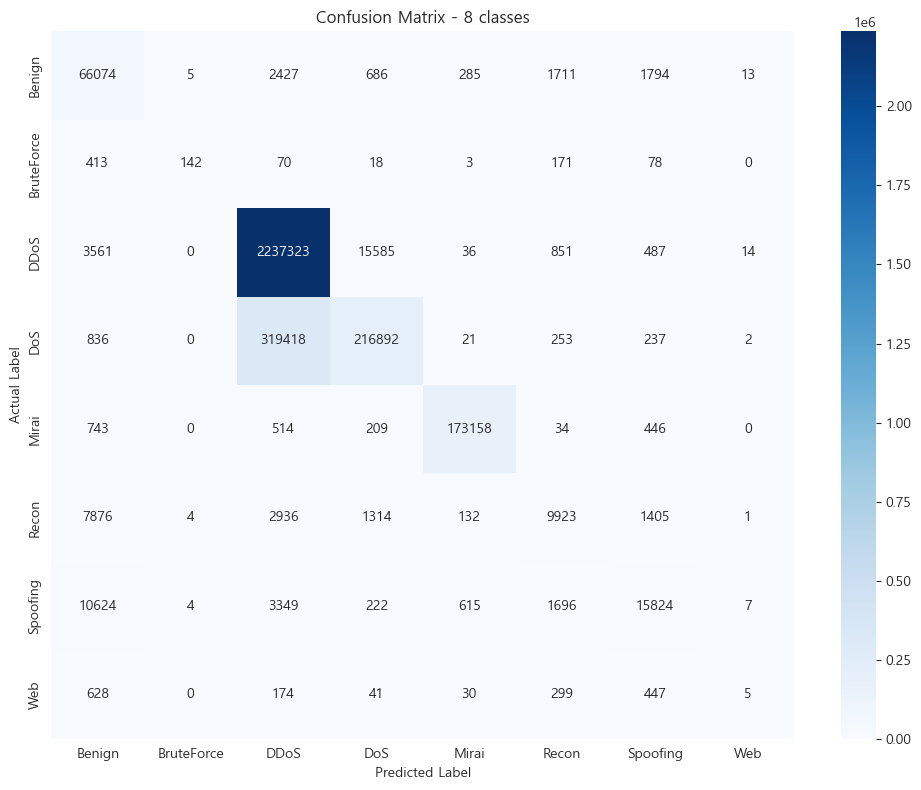

In [19]:
# # 3. 성능 지표 출력 및 해석
def print_evaluation_metrics(model_name, y_true, y_pred, average_mode='macro', pos_label=None):
    """PPT의 평가 지표처럼 성능을 출력하는 함수"""
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n##### {model_name} #####")
    print(f"[정확도(Accuracy)]: {accuracy:.4f} (약 {accuracy * 100:.2f}%)")

    print(f"\n[분류 리포트(Classification Report)]: (average='{average_mode}')")
    # zero_division=0: 샘플이 없는 클래스에 대해 0으로 처리
    report = classification_report(y_true, y_pred, zero_division=0)
    print(report)

    # binary 모드일 때 pos_label을 전달
    if average_mode == 'binary' and pos_label is not None:
        print(
            f"* Precision (정밀도 - {average_mode}): {precision_score(y_true, y_pred, average=average_mode, pos_label=pos_label, zero_division=0):.4f}")
        print(f"* Recall (재현율 - {average_mode}): {recall_score(y_true, y_pred, average=average_mode, pos_label=pos_label, zero_division=0):.4f}")
        print(f"* F1-score (조화 평균 - {average_mode}): {f1_score(y_true, y_pred, average=average_mode, pos_label=pos_label, zero_division=0):.4f}")
    else:
        print(
            f"* Precision (정밀도 - {average_mode}): {precision_score(y_true, y_pred, average=average_mode, zero_division=0):.4f}")
        print(f"* Recall (재현율 - {average_mode}): {recall_score(y_true, y_pred, average=average_mode, zero_division=0):.4f}")
        print(f"* F1-score (조화 평균 - {average_mode}): {f1_score(y_true, y_pred, average=average_mode, zero_division=0):.4f}")


# 2진 분류 평가 (Attack/Benign)
print_evaluation_metrics("LogisticRegression (2 classes)",
                         y_test_2, y_pred_2, average_mode='binary', pos_label='Attack')
plot_confusion_matrix(y_test_2, y_pred_2, model_2.classes_,
                      "2 classes", "result_images/eval_cm_2_classes.png")

# 8종 분류 평가
print_evaluation_metrics("LogisticRegression (8 classes)",
                         y_test_8, y_pred_8, average_mode='macro')
plot_confusion_matrix(y_test_8, y_pred_8, model_8.classes_,
                      "8 classes", "result_images/eval_cm_8_classes.png")

# 34종 분류 평가 (Confusion Matrix는 너무 커서 비활성화)
print_evaluation_metrics("LogisticRegression (34 classes)",
                         y_test_34, y_pred_34, average_mode='macro')


--- 4-1. 보너스: 특성 영향력 (2-Class 모델) ---
('Attack' 클래스 기준 계수)

[특성(Feature)이 'Attack' 탐지에 미치는 영향력 (계수)]
            Feature  Coefficient
1     Header_Length    -2.730324
18        rst_count     2.566809
30             ICMP    -1.888060
0     flow_duration    -1.697406
8   syn_flag_number    -1.284212
44         Variance     1.264129
9   rst_flag_number    -1.016839
35              Max     0.726002
26              TCP    -0.676566
11  ack_flag_number     0.633153

[시각화] 'eval_feature_importance_positive.png' 저장 완료
[시각화] 'eval_feature_importance_negative.png' 저장 완료

--- 모든 작업 완료 ---


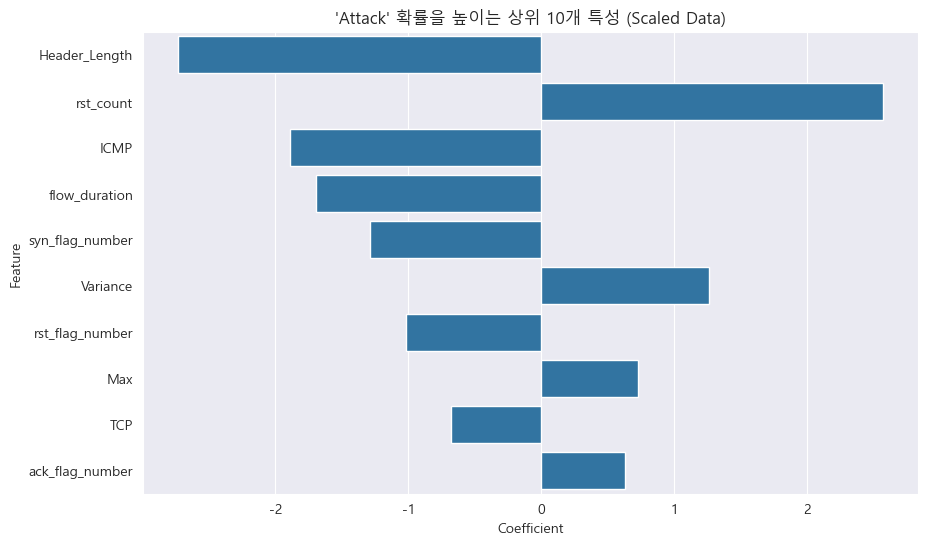

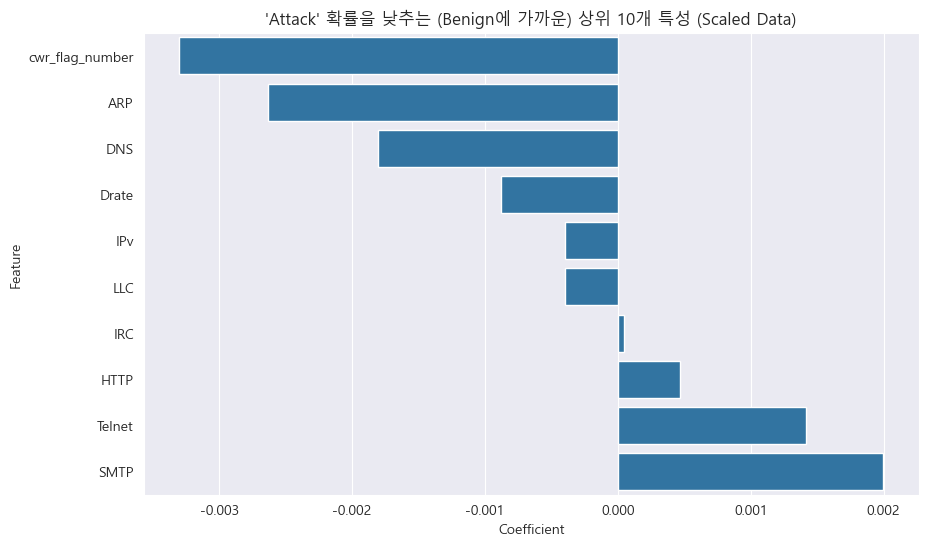

In [20]:
# --- 4-1. 보너스 – 특성이 공격/정상에 미치는 영향력 ---
print(f"\n--- 4-1. 보너스: 특성 영향력 (2-Class 모델) ---")
try:
    target_class_index = list(model_2.classes_).index('Attack')
    print(f"('{model_2.classes_[target_class_index]}' 클래스 기준 계수)")

    coefficients = model_2.coef_[target_class_index]
    coef_df = pd.DataFrame({'Feature': X_columns, 'Coefficient': coefficients})
    coef_df['abs_coef'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

    print("\n[특성(Feature)이 'Attack' 탐지에 미치는 영향력 (계수)]")
    print(coef_df[['Feature', 'Coefficient']].head(10))

    # 보너스 시각화 (상위/하위 10개)
    top_n = 10
    bottom_n = 10
    top_features = coef_df.head(top_n)
    bottom_features = coef_df.tail(bottom_n).sort_values(by='Coefficient', ascending=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=top_features)
    plt.title(f"'Attack' 확률을 높이는 상위 {top_n}개 특성 (Scaled Data)")
    plt.savefig("eval_feature_importance_positive.png", bbox_inches='tight')
    print(f"\n[시각화] 'eval_feature_importance_positive.png' 저장 완료")

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=bottom_features)
    plt.title(f"'Attack' 확률을 낮추는 (Benign에 가까운) 상위 {bottom_n}개 특성 (Scaled Data)")
    plt.savefig("eval_feature_importance_negative.png", bbox_inches='tight')
    print(f"[시각화] 'eval_feature_importance_negative.png' 저장 완료")

except Exception as e:
    print(f"시각화 (특성 영향력) 오류: {e}")

print("\n--- 모든 작업 완료 ---")

--- 8-Class 모델 특성 중요도 시각화 ---
[시각화] 'eval_feature_importance_8class_dos_positive.png' 저장 완료
[시각화] 'eval_feature_importance_8class_mirai_positive.png' 저장 완료


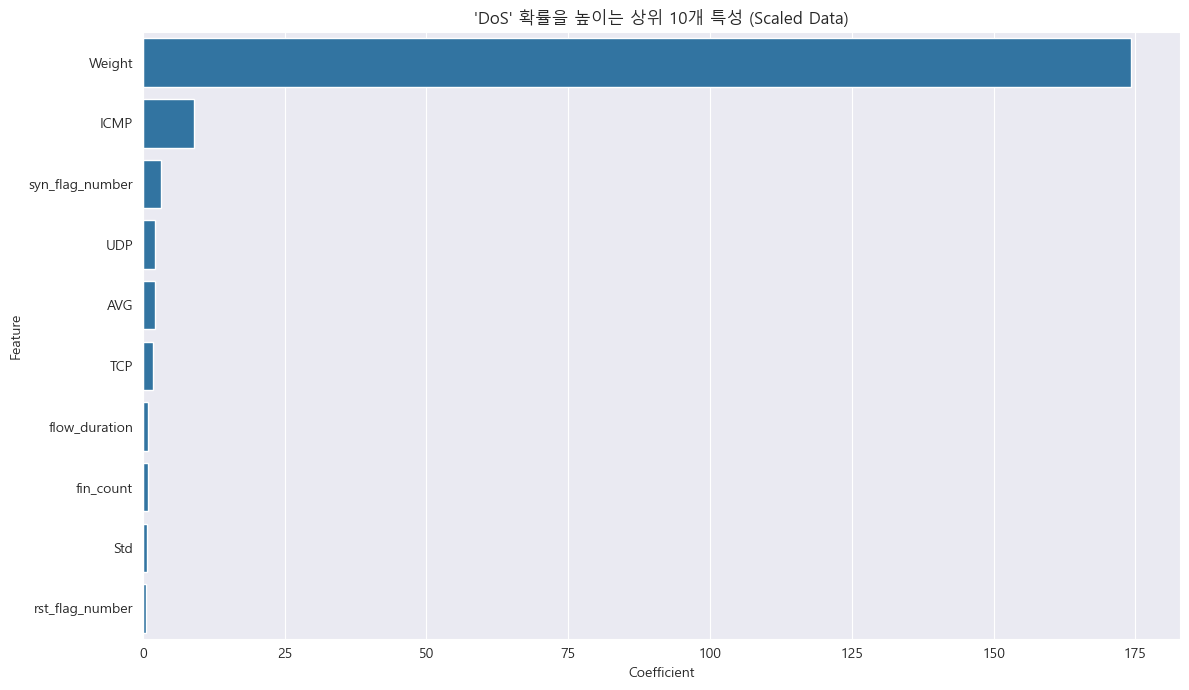

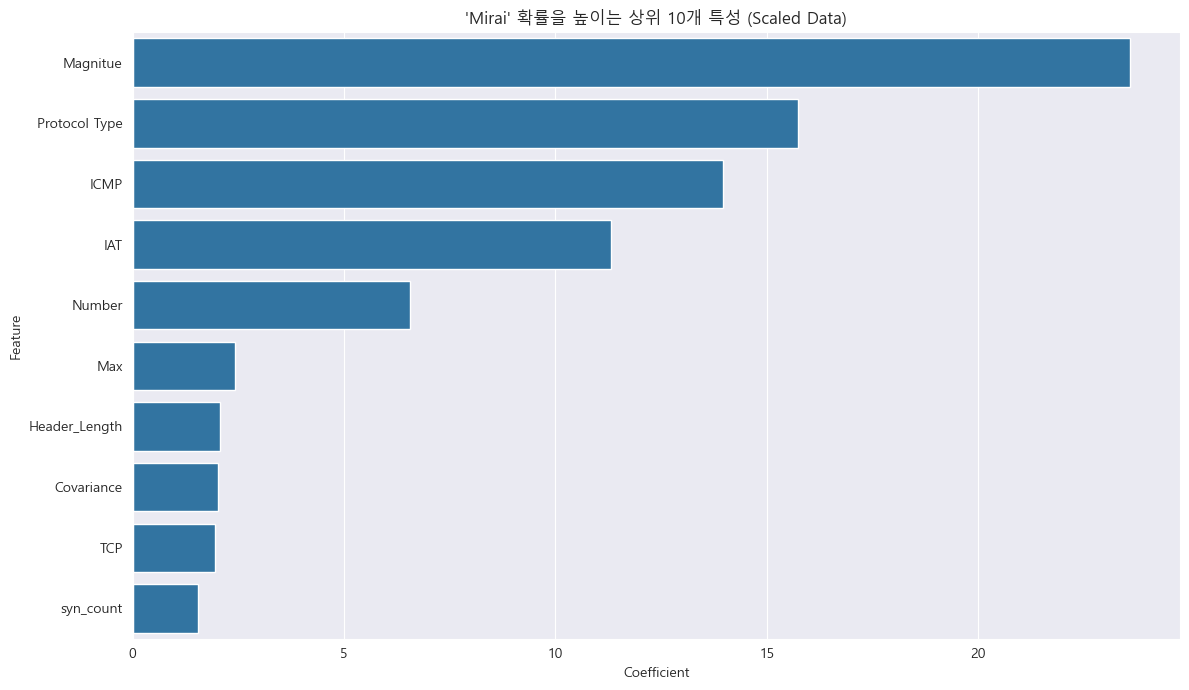

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (선택) 한글 폰트 설정 (시각화 시)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
except:
    pass  # Windows가 아닐 경우 무시
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print("--- 8-Class 모델 특성 중요도 시각화 ---")

# model_8과 X_columns는 이전 셀(cell 7, cell 4)에서 실행되어 메모리에 존재한다고 가정합니다.
# X_columns = ['flow_duration', ... ] # (46개)
# model_8 = LogisticRegression(...) # (학습 완료됨)

try:
    # --- 1. 'DoS' 클래스 분석 ---
    # 8-Class 모델의 성능이 낮았던 클래스 (F1-score: 0.46)
    target_class_dos = 'DoS'
    if target_class_dos in model_8.classes_:
        class_index_dos = list(model_8.classes_).index(target_class_dos)
        coef_dos = model_8.coef_[class_index_dos]

        coef_df_dos = pd.DataFrame({'Feature': X_columns, 'Coefficient': coef_dos})
        # 'DoS' 확률에 가장 긍정적인 영향을 주는 상위 10개 특성
        top_10_dos = coef_df_dos.sort_values(by='Coefficient', ascending=False).head(10)

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Coefficient', y='Feature', data=top_10_dos)
        plt.title(f"'{target_class_dos}' 확률을 높이는 상위 10개 특성 (Scaled Data)")
        plt.tight_layout()
        plt.savefig("eval_feature_importance_8class_dos_positive.png")
        print(f"[시각화] 'eval_feature_importance_8class_dos_positive.png' 저장 완료")
    else:
        print(f"오류: '{target_class_dos}' 클래스를 model_8.classes_에서 찾을 수 없습니다.")

    # --- 2. 'Mirai' 클래스 분석 ---
    # 8-Class 모델의 성능이 높았던 클래스 (F1-score: 0.99)
    target_class_mirai = 'Mirai'
    if target_class_mirai in model_8.classes_:
        class_index_mirai = list(model_8.classes_).index(target_class_mirai)
        coef_mirai = model_8.coef_[class_index_mirai]

        coef_df_mirai = pd.DataFrame({'Feature': X_columns, 'Coefficient': coef_mirai})
        # 'Mirai' 확률에 가장 긍정적인 영향을 주는 상위 10개 특성
        top_10_mirai = coef_df_mirai.sort_values(by='Coefficient', ascending=False).head(10)

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Coefficient', y='Feature', data=top_10_mirai)
        plt.title(f"'{target_class_mirai}' 확률을 높이는 상위 10개 특성 (Scaled Data)")
        plt.tight_layout()
        plt.savefig("eval_feature_importance_8class_mirai_positive.png")
        print(f"[시각화] 'eval_feature_importance_8class_mirai_positive.png' 저장 완료")
    else:
        print(f"오류: '{target_class_mirai}' 클래스를 model_8.classes_에서 찾을 수 없습니다.")

except NameError as ne:
    print(f"오류: {ne}. 'model_8' 또는 'X_columns' 변수가 초기화되지 않았습니다.")
    print("이전 노트북 셀들이 모두 실행되었는지 확인하세요.")
except Exception as e:
    print(f"8-Class 특성 중요도 시각화 중 오류 발생: {e}")
    if 'model_8' in locals():
        print(f"사용 가능한 클래스: {list(model_8.classes_)}")

In [22]:
# # 1. 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier

print("--- 5. 랜덤 포레스트 모델 훈련 시작 ---")
print("RandomForestClassifier 임포트 완료.")

--- 5. 랜덤 포레스트 모델 훈련 시작 ---
RandomForestClassifier 임포트 완료.


In [26]:
print("\n[모델 생성 및 훈련]")
print("RandomForest (2 classes) 훈련 시작...")
print("(로지스틱 회귀보다 훈련 시간이 오래 걸릴 수 있습니다...)")

# n_jobs=-1 : 모든 CPU 코어 사용
# random_state=42 : 재현성을 위한 고정
rf_model_2 = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model_2.fit(X_train, y_train_2)


[모델 생성 및 훈련]
RandomForest (2 classes) 훈련 시작...
(로지스틱 회귀보다 훈련 시간이 오래 걸릴 수 있습니다...)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



[모델 평가]

##### RandomForest (2 classes) #####
[정확도(Accuracy)]: 0.9976 (약 99.76%)

[분류 리포트(Classification Report)]: (average='binary')
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00   3029071
      Benign       0.94      0.96      0.95     72995

    accuracy                           1.00   3102066
   macro avg       0.97      0.98      0.97   3102066
weighted avg       1.00      1.00      1.00   3102066

* Precision (정밀도 - binary): 0.9991
* Recall (재현율 - binary): 0.9985
* F1-score (조화 평균 - binary): 0.9988
[시각화] 'eval_cm_rf_2_classes.png' 저장 완료


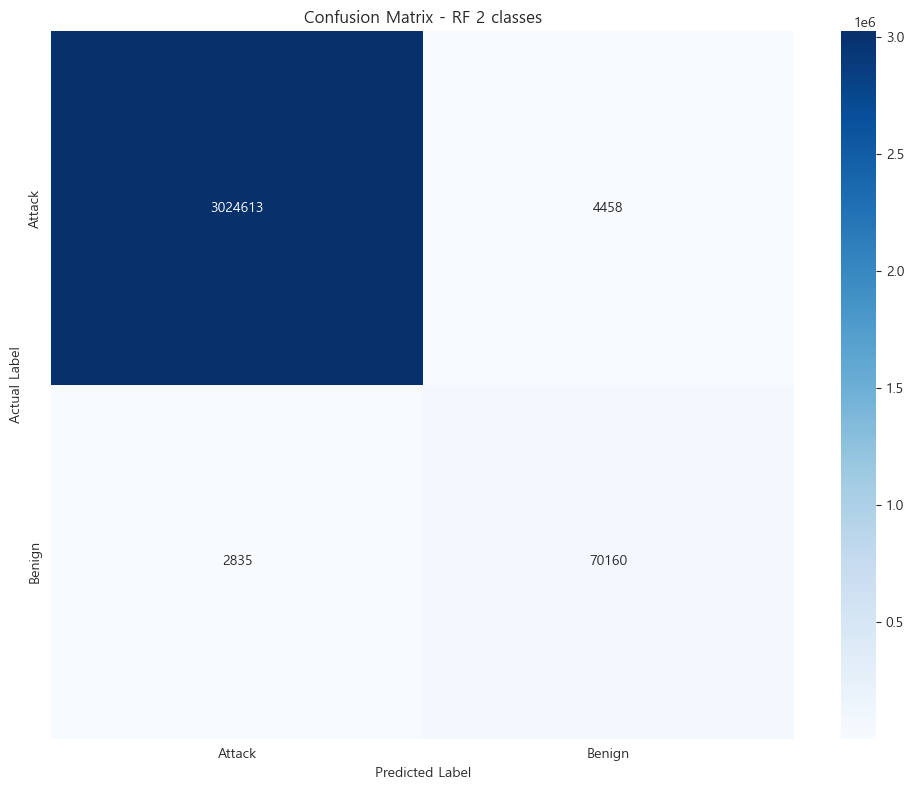

In [28]:
print("\n[모델 평가]")
y_pred_rf_2 = rf_model_2.predict(X_test)

# 이전에 정의한 평가 함수 재사용
print_evaluation_metrics("RandomForest (2 classes)", y_test_2, y_pred_rf_2, average_mode='binary', pos_label='Attack')
plot_confusion_matrix(y_test_2, y_pred_rf_2, rf_model_2.classes_,
                      "RF 2 classes", "result_images/eval_cm_rf_2_classes.png")

In [29]:
print("\n[모델 생성 및 훈련]")
print("RandomForest (8 classes) 훈련 시작...")

rf_model_8 = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model_8.fit(X_train, y_train_8)


[모델 생성 및 훈련]
RandomForest (8 classes) 훈련 시작...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



[모델 평가]

##### RandomForest (8 classes) #####
[정확도(Accuracy)]: 0.9963 (약 99.63%)

[분류 리포트(Classification Report)]: (average='macro')
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95     72995
  BruteForce       0.99      0.53      0.69       895
        DDoS       1.00      1.00      1.00   2257857
         DoS       1.00      1.00      1.00    537659
       Mirai       1.00      1.00      1.00    175104
       Recon       0.91      0.83      0.87     23591
    Spoofing       0.91      0.87      0.89     32341
         Web       0.98      0.39      0.56      1624

    accuracy                           1.00   3102066
   macro avg       0.96      0.83      0.87   3102066
weighted avg       1.00      1.00      1.00   3102066

* Precision (정밀도 - macro): 0.9634
* Recall (재현율 - macro): 0.8253
* F1-score (조화 평균 - macro): 0.8696
[시각화] 'eval_cm_rf_8_classes.png' 저장 완료


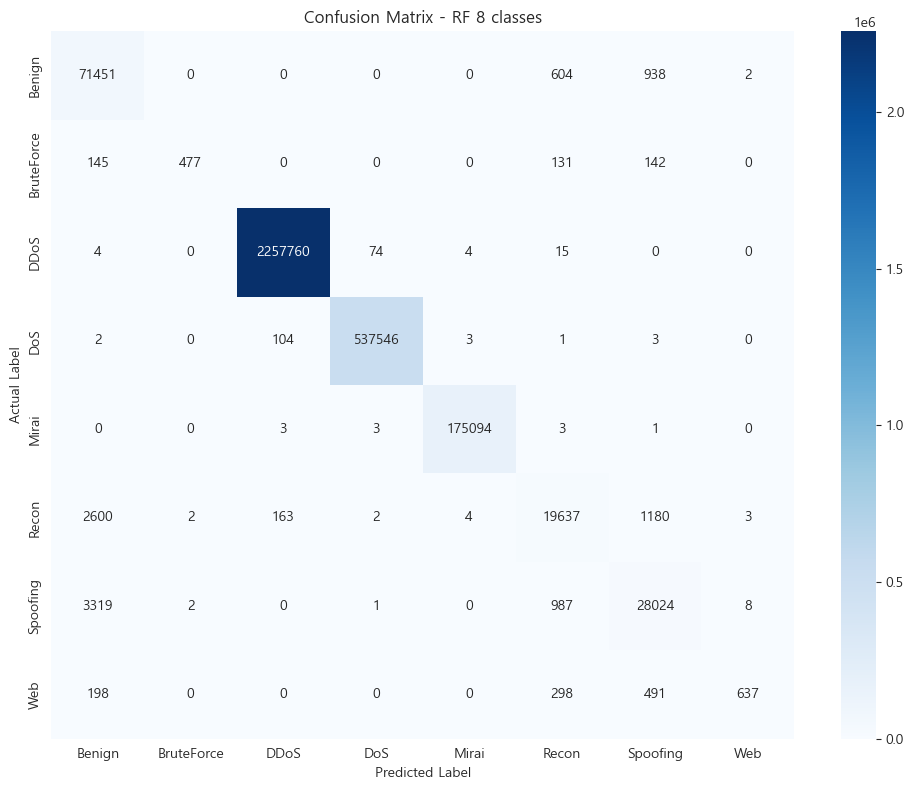

In [30]:
print("\n[모델 평가]")
y_pred_rf_8 = rf_model_8.predict(X_test)

# 이전에 정의한 평가 함수 재사용
print_evaluation_metrics("RandomForest (8 classes)", y_test_8, y_pred_rf_8, average_mode='macro')
plot_confusion_matrix(y_test_8, y_pred_rf_8, rf_model_8.classes_,
                      "RF 8 classes", "result_images/eval_cm_rf_8_classes.png")

In [33]:
print("\n[모델 생성 및 훈련]")
print("RandomForest (34 classes) 훈련 시작...")

rf_model_34 = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model_34.fit(X_train, y_train_34)


[모델 생성 및 훈련]
RandomForest (34 classes) 훈련 시작...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
print("\n[모델 평가]")
y_pred_rf_34 = rf_model_34.predict(X_test)

# 이전에 정의한 평가 함수 재사용
print_evaluation_metrics("RandomForest (34 classes)", y_test_34, y_pred_rf_34, average_mode='macro')

print("\n--- 랜덤 포레스트 모델 훈련 및 평가 완료 ---")


[모델 평가]

##### RandomForest (34 classes) #####
[정확도(Accuracy)]: 0.9950 (약 99.50%)

[분류 리포트(Classification Report)]: (average='macro')
                         precision    recall  f1-score   support

       Backdoor_Malware       0.86      0.08      0.15       218
          BenignTraffic       0.90      0.99      0.94     72995
       BrowserHijacking       0.95      0.28      0.44       376
       CommandInjection       0.88      0.29      0.43       343
 DDoS-ACK_Fragmentation       1.00      1.00      1.00     18818
        DDoS-HTTP_Flood       1.00      0.99      0.99      1935
        DDoS-ICMP_Flood       1.00      1.00      1.00    478436
DDoS-ICMP_Fragmentation       1.00      1.00      1.00     30217
      DDoS-PSHACK_Flood       1.00      1.00      1.00    272375
       DDoS-RSTFINFlood       1.00      1.00      1.00    268838
         DDoS-SYN_Flood       1.00      1.00      1.00    270248
         DDoS-SlowLoris       0.95      0.99      0.97      1582
DDoS-SynonymousIP_F


--- 5-1. 보너스: 특성 영향력 (Random Forest 2-Class 모델) ---

[특성(Feature)이 'Attack' 탐지에 미치는 영향력 (중요도)]
          Feature  Importance
39            IAT    0.152009
18      rst_count    0.143185
17      urg_count    0.118485
0   flow_duration    0.099682
3        Duration    0.070442
40         Number    0.059938
45         Weight    0.046346
1   Header_Length    0.037132
44       Variance    0.028496
4            Rate    0.028093

[시각화] 'eval_rf_feature_importance.png' 저장 완료


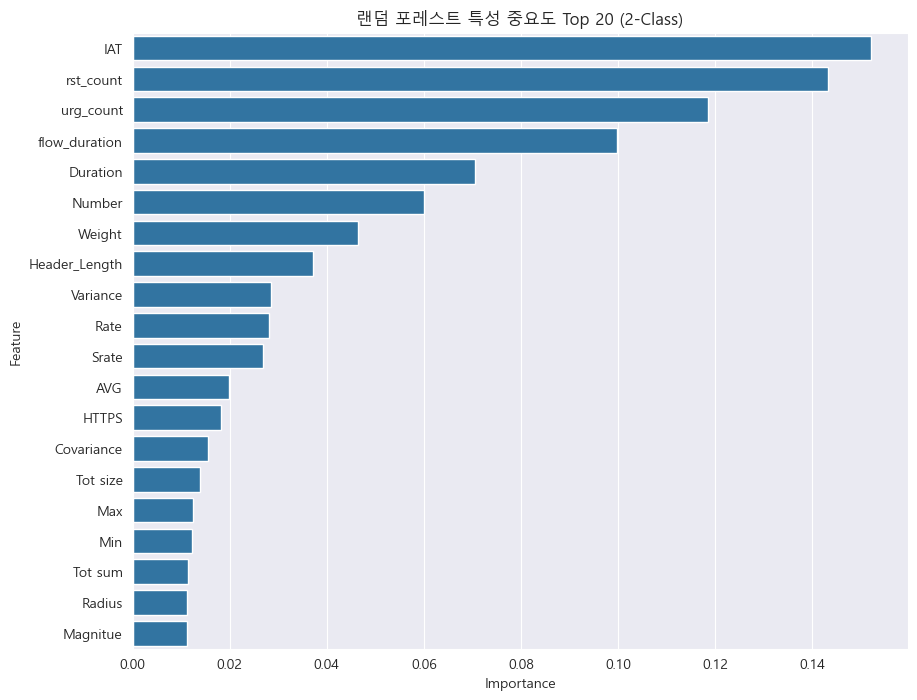

In [35]:
print(f"\n--- 5-1. 보너스: 특성 영향력 (Random Forest 2-Class 모델) ---")

try:
    # 랜덤 포레스트는 .feature_importances_ 속성을 사용
    rf_importances = rf_model_2.feature_importances_

    rf_coef_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': rf_importances
    })

    # 중요도(Importance)가 높은 순서대로 정렬
    rf_coef_df = rf_coef_df.sort_values(by='Importance', ascending=False)

    print("\n[특성(Feature)이 'Attack' 탐지에 미치는 영향력 (중요도)]")
    print(rf_coef_df.head(10))  # 상위 10개

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_coef_df.head(20))  # 상위 20개
    plt.title(f"랜덤 포레스트 특성 중요도 Top 20 (2-Class)")
    plt.savefig("eval_rf_feature_importance.png", bbox_inches='tight')
    print(f"\n[시각화] 'eval_rf_feature_importance.png' 저장 완료")

except Exception as e:
    print(f"시각화 (RF 특성 중요도) 오류: {e}")


--- 5-2. 보너스: 랜덤 포레스트 8-Class 및 34-Class 모델 특성 중요도 ---

[8-Class RF 모델 특성 중요도 Top 10]
          Feature  Importance
39            IAT    0.492823
0   flow_duration    0.043519
34            Min    0.041946
2   Protocol Type    0.039439
41       Magnitue    0.038877
36            AVG    0.037150
1   Header_Length    0.033293
35            Max    0.032070
33        Tot sum    0.027046
38       Tot size    0.024995

[시각화] 'eval_rf_8_feature_importance.png' 저장 완료

[34-Class RF 모델 특성 중요도 Top 10]
            Feature  Importance
39              IAT    0.265763
41         Magnitue    0.051186
36              AVG    0.048623
15        syn_count    0.047899
2     Protocol Type    0.044788
34              Min    0.039642
1     Header_Length    0.037658
8   syn_flag_number    0.036902
10  psh_flag_number    0.035754
33          Tot sum    0.035476
[시각화] 'eval_rf_34_feature_importance.png' 저장 완료

--- 특성 중요도 분석 완료 ---


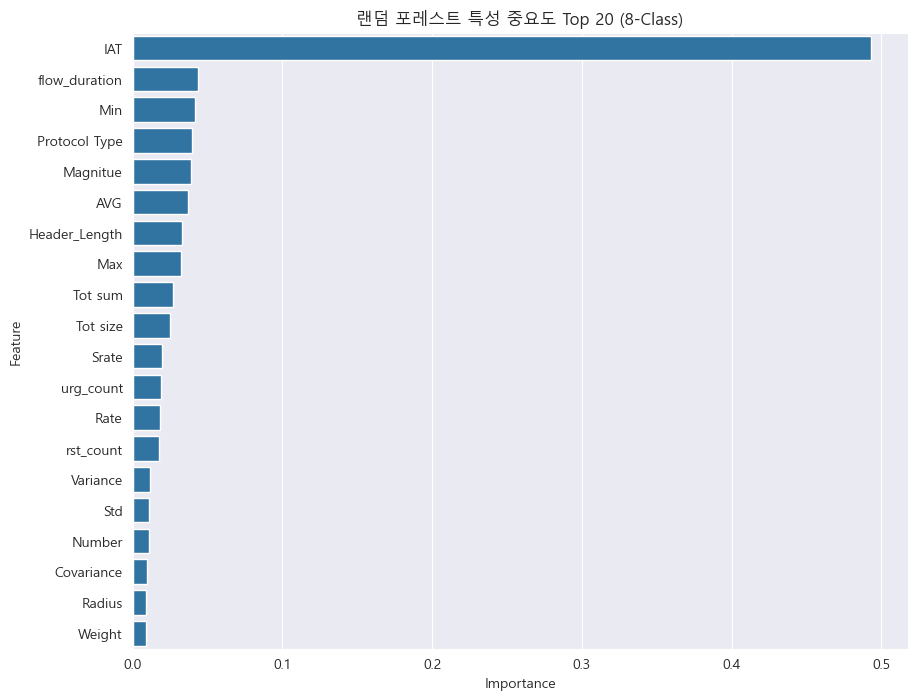

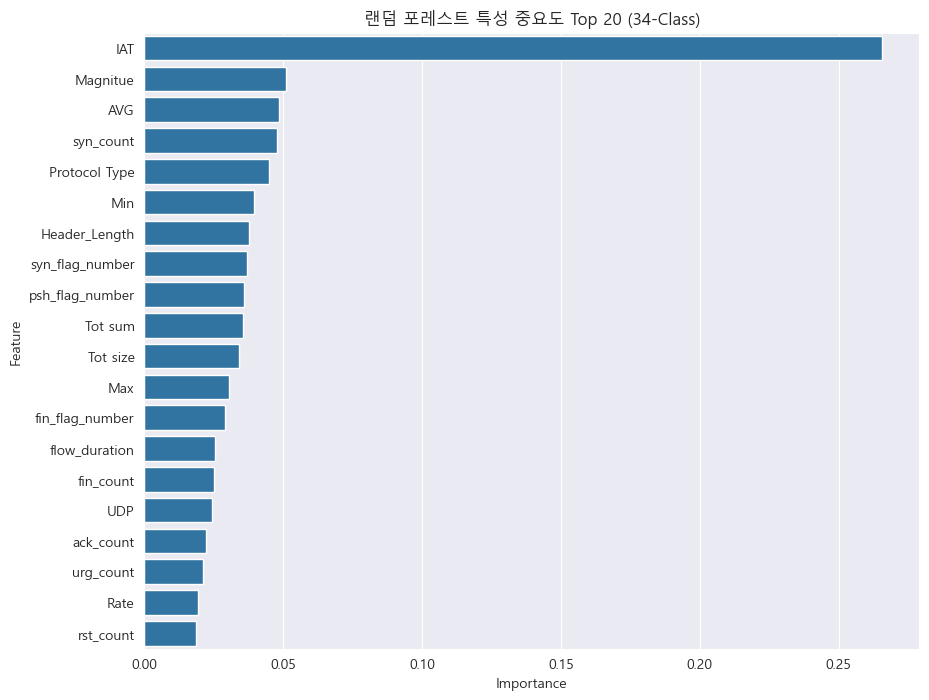

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (선택) 한글 폰트 설정 (시각화 시)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
except:
    pass  # Windows가 아닐 경우 무시
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print("\n--- 5-2. 보너스: 랜덤 포레스트 8-Class 및 34-Class 모델 특성 중요도 ---")

# X_columns, rf_model_8, rf_model_34는 이전 셀에서 실행되어 메모리에 있다고 가정합니다.

try:
    # --- 1. 8-Class RF 모델 분석 ---
    # feature_importances_ 속성은 모델 전체의 특성 중요도를 나타냅니다.
    rf_importances_8 = rf_model_8.feature_importances_
    rf_coef_df_8 = pd.DataFrame({
        'Feature': X_columns,
        'Importance': rf_importances_8
    }).sort_values(by='Importance', ascending=False)

    print("\n[8-Class RF 모델 특성 중요도 Top 10]")
    print(rf_coef_df_8.head(10))

    # 상위 20개 특성 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_coef_df_8.head(20))
    plt.title("랜덤 포레스트 특성 중요도 Top 20 (8-Class)")
    plt.savefig("eval_rf_8_feature_importance.png", bbox_inches='tight')
    print("\n[시각화] 'eval_rf_8_feature_importance.png' 저장 완료")

    # --- 2. 34-Class RF 모델 분석 ---
    rf_importances_34 = rf_model_34.feature_importances_
    rf_coef_df_34 = pd.DataFrame({
        'Feature': X_columns,
        'Importance': rf_importances_34
    }).sort_values(by='Importance', ascending=False)

    print("\n[34-Class RF 모델 특성 중요도 Top 10]")
    print(rf_coef_df_34.head(10))

    # 상위 20개 특성 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_coef_df_34.head(20))
    plt.title("랜덤 포레스트 특성 중요도 Top 20 (34-Class)")
    plt.savefig("eval_rf_34_feature_importance.png", bbox_inches='tight')
    print("[시각화] 'eval_rf_34_feature_importance.png' 저장 완료")

except NameError as ne:
    print(f"오류: {ne}. 'rf_model_8', 'rf_model_34' 또는 'X_columns' 변수가 초기화되지 않았습니다.")
    print("이전 노트북 셀들이 모두 실행되었는지 확인하세요.")
except Exception as e:
    print(f"시각화 (RF 특성 중요도) 오류: {e}")

print("\n--- 특성 중요도 분석 완료 ---")

In [1]:
# --- 6. 부스팅 모델 준비 (라이브러리 임포트 및 레이블 인코딩) ---
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

print("\n--- 6. 부스팅 모델(XGBoost, LightGBM) 준비 ---")

# 레이블 인코더 생성 및 변환 (2, 8, 34 클래스 각각)
le_2 = LabelEncoder()
y_train_2_enc = le_2.fit_transform(y_train_2)
y_test_2_enc = le_2.transform(y_test_2)

le_8 = LabelEncoder()
y_train_8_enc = le_8.fit_transform(y_train_8)
y_test_8_enc = le_8.transform(y_test_8)

le_34 = LabelEncoder()
y_train_34_enc = le_34.fit_transform(y_train_34)
y_test_34_enc = le_34.transform(y_test_34)

print("레이블 인코딩 완료 (String -> Integer 변환)")
print(f"2-Class 예시: {le_2.classes_}")


--- 6. 부스팅 모델(XGBoost, LightGBM) 준비 ---


NameError: name 'y_train_2' is not defined

In [ ]:
# --- 7. XGBoost 모델 훈련 및 평가 ---
print(f"\n--- 7. XGBoost 모델 훈련 ---")

# 1. XGBoost 2-Class
print("\n[XGBoost] 2-Class (Binary) 훈련 중...")
xgb_model_2 = XGBClassifier(n_jobs=-1, random_state=42, eval_metric='logloss')
xgb_model_2.fit(X_train, y_train_2_enc)

# 예측 및 역변환 (숫자 -> 문자열)
y_pred_xgb_2_enc = xgb_model_2.predict(X_test)
y_pred_xgb_2 = le_2.inverse_transform(y_pred_xgb_2_enc)

# 평가
print_evaluation_metrics("XGBoost (2 classes)", y_test_2, y_pred_xgb_2, average_mode='binary', pos_label='Attack')
plot_confusion_matrix(y_test_2, y_pred_xgb_2, le_2.classes_, "XGBoost 2 classes", "eval_cm_xgb_2_classes.png")


# 2. XGBoost 8-Class
print("\n[XGBoost] 8-Class (Multi-class) 훈련 중...")
xgb_model_8 = XGBClassifier(n_jobs=-1, random_state=42, eval_metric='mlogloss')
xgb_model_8.fit(X_train, y_train_8_enc)

y_pred_xgb_8_enc = xgb_model_8.predict(X_test)
y_pred_xgb_8 = le_8.inverse_transform(y_pred_xgb_8_enc)

print_evaluation_metrics("XGBoost (8 classes)", y_test_8, y_pred_xgb_8, average_mode='macro')
plot_confusion_matrix(y_test_8, y_pred_xgb_8, le_8.classes_, "XGBoost 8 classes", "eval_cm_xgb_8_classes.png")


# 3. XGBoost 34-Class
print("\n[XGBoost] 34-Class (Multi-class) 훈련 중 (시간이 소요될 수 있습니다)...")
xgb_model_34 = XGBClassifier(n_jobs=-1, random_state=42, eval_metric='mlogloss')
xgb_model_34.fit(X_train, y_train_34_enc)

y_pred_xgb_34_enc = xgb_model_34.predict(X_test)
y_pred_xgb_34 = le_34.inverse_transform(y_pred_xgb_34_enc)

print_evaluation_metrics("XGBoost (34 classes)", y_test_34, y_pred_xgb_34, average_mode='macro')

In [ ]:
# --- 8. LightGBM 모델 훈련 및 평가 ---
print(f"\n--- 8. LightGBM 모델 훈련 ---")

# 1. LightGBM 2-Class
print("\n[LightGBM] 2-Class (Binary) 훈련 중...")
# verbose=-1: 경고 메시지 최소화
lgbm_model_2 = LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)
lgbm_model_2.fit(X_train, y_train_2_enc)

y_pred_lgbm_2_enc = lgbm_model_2.predict(X_test)
y_pred_lgbm_2 = le_2.inverse_transform(y_pred_lgbm_2_enc)

print_evaluation_metrics("LightGBM (2 classes)", y_test_2, y_pred_lgbm_2, average_mode='binary', pos_label='Attack')
plot_confusion_matrix(y_test_2, y_pred_lgbm_2, le_2.classes_, "LightGBM 2 classes", "eval_cm_lgbm_2_classes.png")


# 2. LightGBM 8-Class
print("\n[LightGBM] 8-Class (Multi-class) 훈련 중...")
lgbm_model_8 = LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)
lgbm_model_8.fit(X_train, y_train_8_enc)

y_pred_lgbm_8_enc = lgbm_model_8.predict(X_test)
y_pred_lgbm_8 = le_8.inverse_transform(y_pred_lgbm_8_enc)

print_evaluation_metrics("LightGBM (8 classes)", y_test_8, y_pred_lgbm_8, average_mode='macro')
plot_confusion_matrix(y_test_8, y_pred_lgbm_8, le_8.classes_, "LightGBM 8 classes", "eval_cm_lgbm_8_classes.png")


# 3. LightGBM 34-Class
print("\n[LightGBM] 34-Class (Multi-class) 훈련 중...")
lgbm_model_34 = LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)
lgbm_model_34.fit(X_train, y_train_34_enc)

y_pred_lgbm_34_enc = lgbm_model_34.predict(X_test)
y_pred_lgbm_34 = le_34.inverse_transform(y_pred_lgbm_34_enc)

print_evaluation_metrics("LightGBM (34 classes)", y_test_34, y_pred_lgbm_34, average_mode='macro')

In [ ]:
print(f"\n--- 9. 부스팅 모델 특성 중요도 분석 (8-Class 기준) ---")

try:
    # XGBoost Feature Importance
    xgb_imp = xgb_model_8.feature_importances_

    # LightGBM Feature Importance
    lgbm_imp = lgbm_model_8.feature_importances_
    # LightGBM은 중요도 스케일이 다르므로 정규화(normalize)
    lgbm_imp = lgbm_imp / lgbm_imp.sum()

    # 데이터프레임 생성
    imp_df = pd.DataFrame({
        'Feature': X_columns,
        'XGBoost': xgb_imp,
        'LightGBM': lgbm_imp
    })

    # XGBoost 기준 정렬
    imp_df = imp_df.sort_values(by='XGBoost', ascending=False).head(15)

    # 시각화 (Melt for seaborn)
    imp_melted = imp_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Importance', y='Feature', hue='Model', data=imp_melted)
    plt.title("XGBoost vs LightGBM 특성 중요도 비교 (Top 15, 8-Class)")
    plt.tight_layout()
    plt.savefig("eval_boosting_feature_importance.png")
    print("[시각화] 'eval_boosting_feature_importance.png' 저장 완료")

except Exception as e:
    print(f"특성 중요도 시각화 중 오류: {e}")